In [2]:
import os, glob, re
import shutil
import gzip
from os.path import join
import nilearn
from nilearn import image, plotting, masking
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

1. grab numpy array
2. mask run 1 and run 2
3. check if they plot correctly back into a brain map (nii)
4. calculated correlation between run 1 and run 2
5. save it in a table
* create table (18 x 18)
* extract ses and filename from each file
* compare index
* add correlation value using iloc

6. in a plot, outline the bad runs
7. plot runs by overlaying each other
8. get top 3 bad correlation

## 1. grab numpy array

In [3]:
npy_dir = '/Volumes/fmriprep_qc/numpy_bold'
fmriprep_dir = '/Volumes/fmriprep'

sub = 'sub-0002'
run_X_num = (1,1)
run_Y_num = (3,4)
run_X = join(npy_dir, sub, f"{sub}_ses-{run_X_num[0]:02d}_task-social_acq-mb8_run-{run_X_num[1]:01d}_space-MNI152NLin2009cAsym_desc-preproc_bold.npy")
run_Y = join(npy_dir, sub, f"{sub}_ses-{run_Y_num[0]:02d}_task-social_acq-mb8_run-{run_Y_num[1]:01d}_space-MNI152NLin2009cAsym_desc-preproc_bold.npy")

In [4]:
npy_flist = glob.glob(join(npy_dir, sub, '*.npy'), recursive=True)

In [5]:
data = []
pattern = re.compile(r'sub-(\d+)_ses-(\d+)_.*run-(\d+)')
for filename in sorted(npy_flist):
    file = os.path.basename(filename)
    matches = pattern.search(file)
    sub = matches.group(1)
    ses = matches.group(2)
    run = matches.group(3)
    data.append({'sub': sub, 'ses': ses, 'run': run})

# Create DataFrame
df = pd.DataFrame(data)

In [6]:
df.head()

,sub,ses,run
0,0002,01,1
1,0002,01,2
2,0002,01,3
3,0002,01,4
4,0002,01,5


## 2. mask run 1 and run 2

load brain mask

In [7]:
mask_fname = '/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'
mask_fname_gz = mask_fname + '.gz'

with open(mask_fname, 'rb') as f_in:
    with gzip.open(mask_fname_gz, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
brain_mask = image.load_img(mask_fname_gz)

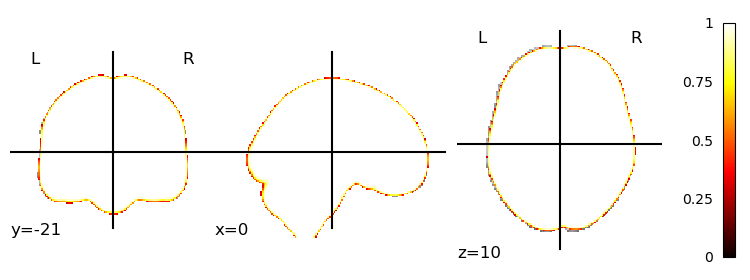

In [8]:
plotting.plot_stat_map(brain_mask)

In [9]:
# imgfname = glob.glob(join(nifti_dir, sub, f'{sub}_{ses}_*_runtype-vicarious_event-{fmri_event}_*_cuetype-low_stimintensity-low.nii.gz'))
ref_img_fname = '/Users/h/Documents/projects_local/sandbox/sub-0061_ses-04_task-social_acq-mb8_run-6_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
ref_img = image.index_img(image.load_img(ref_img_fname),8) #image.load_img(ref_img_fname)
threshold = 0.5
#image.load_img(join(fmriprep_dir, sub, 'ses-01', 'func', 'sub-0002_ses-01_task-social_acq-mb8_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
nifti_masker = nilearn.maskers.NiftiMasker(mask_img= masking.compute_epi_mask(image.load_img(mask_fname_gz), lower_cutoff=threshold, upper_cutoff=1.0),
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [10]:
singlemasked = []
for img_fname in [run_X, run_Y]:
    img = np.load(img_fname)
    singlemasked.append(
        nifti_masker.fit_transform(
    image.new_img_like(ref_img,img))
    )

## 3. check if they plot correctly back into a brain map (nii)

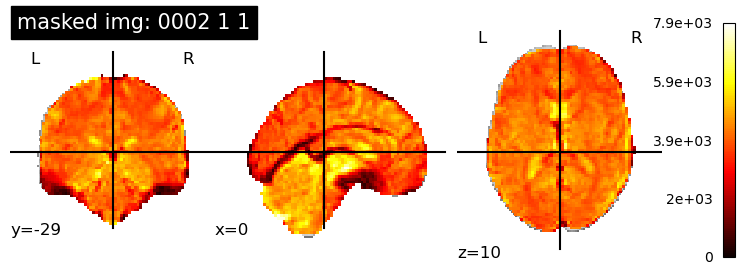

In [11]:
# convert back to 3d brain
masked_arr = nifti_masker.inverse_transform(singlemasked[0])
masked_img = image.new_img_like(ref_img, masked_arr.get_fdata()[..., 0])
ses = run_X_num[0]
run = run_X_num[1]
plotting.plot_stat_map(masked_img, title = f"masked img: {sub} {ses} {run}")
# plt.savefig(join(save_dir, f"maskedimage_{sub}_{ses}.png"))
# plt.close()

In [85]:
report = nifti_masker.generate_report()
report

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:337: UserWarning: No image provided to fit in NiftiMasker. Setting image to mask for reporting.
  warnings.warn(msg)


Parameter,Value
detrend,False
dtype,None
high_pass,None
high_variance_confounds,False
low_pass,None
mask_args,None
mask_img,"<class 'nibabel.nifti1.Nifti1Image'> data shape (121, 145, 121) affine: [[ -1.5 0. 0. 90. ] [ 0. 1.5 0. -126. ] [ 0. 0. 1.5 -72. ] [ 0. 0. 0. 1. ]] metadata: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<' sizeof_hdr : 348 data_type : b'' db_name : b'' extents : 0 session_error : 0 regular : b'' dim_info : 0 dim : [ 3 121 145 121 1 1 1 1] intent_p1 : 0.0 intent_p2 : 0.0 intent_p3 : 0.0 intent_code : none datatype : uint8 bitpix : 8 slice_start : 0 pixdim : [-1. 1.5 1.5 1.5 1. 1. 1. 1. ] vox_offset : 0.0 scl_slope : nan scl_inter : nan slice_end : 0 slice_code : unknown xyzt_units : 0 cal_max : 0.0 cal_min : 0.0 slice_duration : 0.0 toffset : 0.0 glmax : 0 glmin : 0 descrip : b'' aux_file : b'' qform_code : unknown sform_code : aligned quatern_b : 0.0 quatern_c : 1.0 quatern_d : 0.0 qoffset_x : 90.0 qoffset_y : -126.0 qoffset_z : -72.0 srow_x : [-1.5 0. 0. 90. ] srow_y : [ 0. 1.5 0. -126. ] srow_z : [ 0. 0. 1.5 -72. ] intent_name : b'' magic : b'n+1'"
mask_strategy,background
memory,Memory(location=nilearn_cache/joblib)
memory_level,1


In [ ]:
# over

## 4. calculated correlation between run 1 and run 2

In [86]:
singlemasked[0].shape

(872, 99763)

In [88]:
correlation = np.corrcoef(singlemasked[0], singlemasked[1])[0, 1]
correlation

0.9911671831888125

## 5. save it in a table

## 6. in a plot, outline the bad runs


## 7. plot runs by overlaying each other

In [90]:
masked_X = nifti_masker.inverse_transform(singlemasked[0])
masked_Y = nifti_masker.inverse_transform(singlemasked[1])

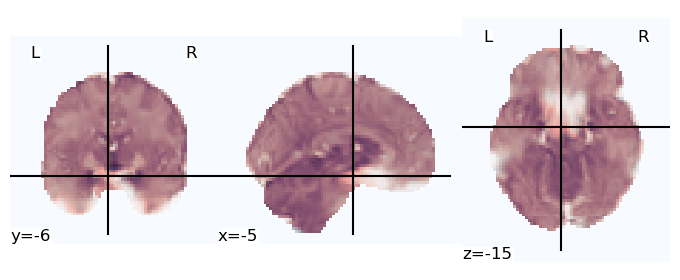

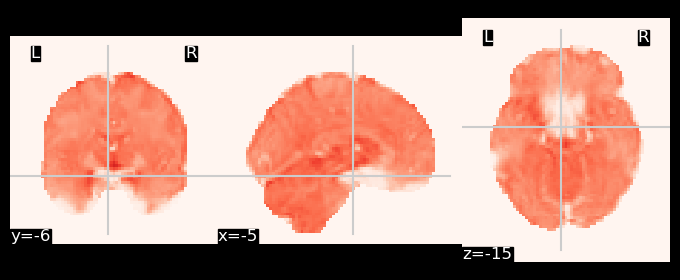

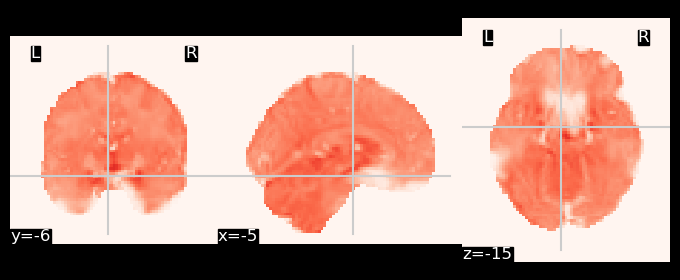

In [135]:
# Plot the first image as the background
# plotting.plot_stat_map(image.mean_img(masked_X), cmap='gray', alpha=0.5, colorbar=False)
# NOTE: REFERENCE: https://neurostars.org/t/how-to-overlay-a-mask-image-on-another-mri-image-using-nilearn-plotting/5185/6
# Overlay the second image on top

coords = (-5, -6, -15)

display = plotting.plot_img(image.mean_img(masked_X), cmap='Blues', alpha=0.9, colorbar=False, cut_coords=coords)
display.add_overlay(image.mean_img(masked_Y), cmap="Reds", alpha = .5)
# display.add_contours(image.mean_img(masked_Y),
#                      linewidths=1, levels=[.5],
#                      colors="cyan")
plotting.plot_anat(image.mean_img(masked_X), cmap='Reds', alpha=1, colorbar=False, cut_coords=coords, display_mode='ortho')
plotting.plot_anat(image.mean_img(masked_Y), cmap='Reds', alpha=1, colorbar=False, cut_coords=coords, display_mode='ortho')
plt.show()


8. get top 3 bad correlation